In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

import warnings
warnings.filterwarnings('ignore')

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

In [93]:
import FinanceDataReader as fdr
fdr.__version__    

stock_code= '233740'
df_kospi = fdr.DataReader(stock_code, '2011') 
# 229200(코스닥) , 251340(코스닥인버스), 233740(코스닥 레버리지), 069500(KODEX 200), 122630(KODEX 레버리지)
print(df_kospi.shape)

(847, 6)


In [94]:
df_kospi.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-12-17,10240,10405,9970,10330,946156,NaN
2015-12-18,10230,10710,10165,10710,1841150,0.036786
2015-12-21,10695,10825,10670,10720,1274858,0.000934
2015-12-22,10740,10750,10450,10495,1374974,-0.020989
2015-12-23,10535,10635,10415,10425,2532341,-0.006670


In [95]:
df_kospi.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-05-30,9870,10040,9710,9850,17496589,0.000508
2019-05-31,9780,10270,9725,10085,20403360,0.023858
2019-06-03,9990,10230,9945,10195,14911646,0.010907
2019-06-04,10150,10325,10135,10245,12030816,0.004904
2019-06-05,10415,10465,10295,10300,10587942,0.005368


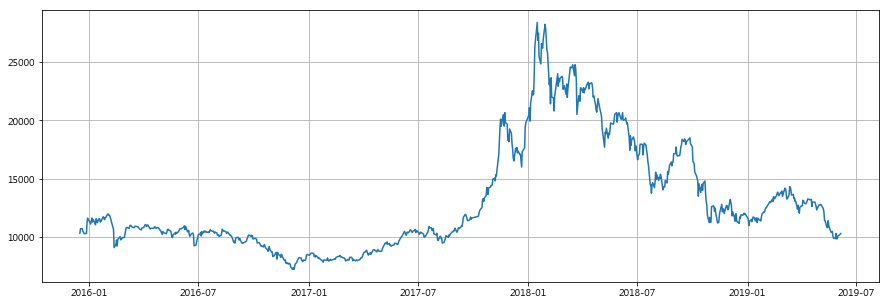

In [96]:
#df_graph= df.loc['20160302':'20181230']
df_graph= df_kospi.copy()
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,1,1)
ax1.plot(df_graph.index, df_graph['Close'])
ax1.grid()
plt.show()

In [100]:
alpha= 2
df_kospi['20MA']= df_kospi['Close'].rolling(window=20).mean()
df_kospi['Upper']= df_kospi['20MA'] + alpha * df_kospi['Close'].rolling(20).std()
df_kospi['Lower']= df_kospi['20MA'] - alpha * df_kospi['Close'].rolling(20).std()


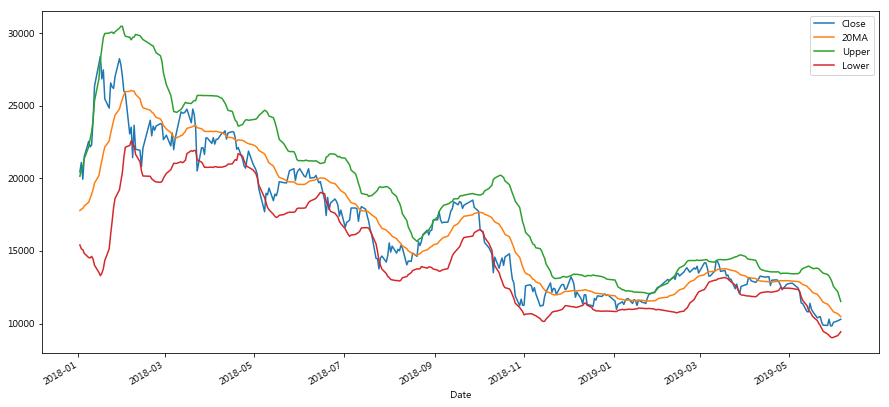

In [101]:
df_kospi[['Close','20MA','Upper','Lower']]['2018':].plot(figsize=(15,7))

- 평균회귀전략: 볼린저밴드, RSI등 과매수,과매도를 나타내는 많은 지표들은 평균회귀지표의 일종
- 볼린저 밴드 만들기 : 20일 이동평균선 +- 표준편차
- 표준정규분포 z-score= (close - mu) / std --> z-score가 1.96과 -1.96사이는 95%, 1과 -1사이는 0.68%
- 평균회귀성을 확인하는 방법? 정상성지표, adf와 허스트지수

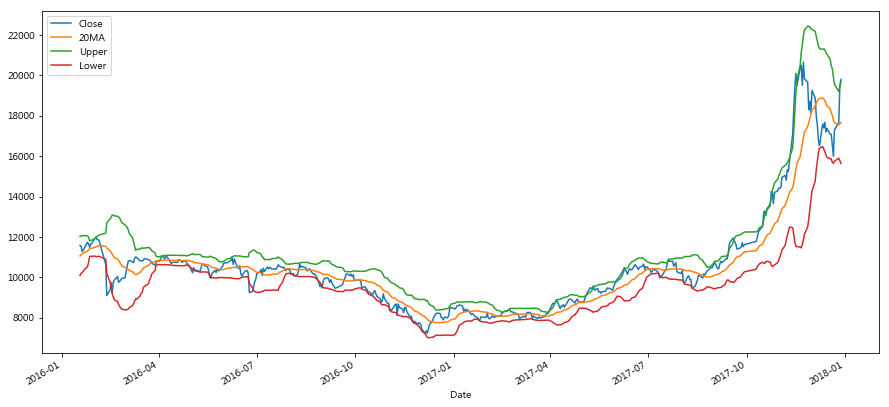

In [61]:
df_kospi[['Close','20MA','Upper','Lower']][:'2017'].plot(figsize=(15,7))

In [50]:
df_kospi.dropna(inplace= True)
df_kospi.head()

,Open,High,Low,Close,Volume,Change,20MA,Upper,Lower
Date,,,,,,,,,
2016-01-18,11100,11575,11085,11575,1900821,0.030721,11060.25,12027.560297,10092.939703
2016-01-19,11510,11680,11380,11550,2014000,-0.002160,11121.25,12047.668542,10194.831458
2016-01-20,11575,11675,10970,11280,2597290,-0.023377,11149.75,12057.787067,10241.712933
2016-01-21,11310,11515,11065,11340,2540576,0.005319,11180.75,12069.132771,10292.367229
2016-01-22,11450,11530,11180,11450,1703580,0.009700,11228.50,12062.697377,10394.302623


- 기본 전략: 평균회귀 전략
- 매수 조건: 전일종가 < Lower, Lower는 (20일 이동평균값)에-2*(20일 표준편차값)이다.
- 매수 가격: 당일 시가 + 1호가
- 매도 조건: 전일종가 > 20일 이동평균값
- 매도 가격: 당일 시가 - 1호가
- 거래 비용: 15.43% (거래 수수료 0.03%, 수익금에 대한 세금: 15.4%)
- 체결 오차(슬리피지): 1호가
- 거래 대상: 
    - KODEX 코스닥 150 (229200)
    - KODEX 코스닥 150 레버리지 (233740)
    - KODEX 코스닥 150 인버스 (251340)
- 연간 투입 자금: 1억 원 (수익금 재투자 또는 고정)
- 보유 종목수: 하루 1개 (한 종목에 몰빵)
- 백테스트 기간: 2016년 1월 4일 - 2019년 6월 4일


In [51]:
df= df_kospi.copy()

In [52]:
df['Close-1']= df['Close'].shift(1)

In [53]:
# datetime을 문자열로 변환
df['일자']= df.index.strftime('%Y%m%d')
df.set_index('일자', inplace= True)
df.head()

,Open,High,Low,Close,Volume,Change,20MA,Upper,Lower,Close-1
일자,,,,,,,,,,
20160118,11100,11575,11085,11575,1900821,0.030721,11060.25,12027.560297,10092.939703,NaN
20160119,11510,11680,11380,11550,2014000,-0.002160,11121.25,12047.668542,10194.831458,11575.0
20160120,11575,11675,10970,11280,2597290,-0.023377,11149.75,12057.787067,10241.712933,11550.0
20160121,11310,11515,11065,11340,2540576,0.005319,11180.75,12069.132771,10292.367229,11280.0
20160122,11450,11530,11180,11450,1703580,0.009700,11228.50,12062.697377,10394.302623,11340.0


In [54]:
df.shape

(828, 10)

In [55]:
df.dropna(inplace= True)
df.head()

,Open,High,Low,Close,Volume,Change,20MA,Upper,Lower,Close-1
일자,,,,,,,,,,
20160119,11510,11680,11380,11550,2014000,-0.002160,11121.25,12047.668542,10194.831458,11575.0
20160120,11575,11675,10970,11280,2597290,-0.023377,11149.75,12057.787067,10241.712933,11550.0
20160121,11310,11515,11065,11340,2540576,0.005319,11180.75,12069.132771,10292.367229,11280.0
20160122,11450,11530,11180,11450,1703580,0.009700,11228.50,12062.697377,10394.302623,11340.0
20160125,11550,11750,11485,11740,1909205,0.025328,11294.25,12066.807441,10521.692559,11450.0


In [57]:
# 함수구조를 2단계로 나누자.
# 전략실행-> buy(1), sell(-1), hold(0)로 구분 -> Trading Signal 컬럼생성
# -> Trading Signal 컬럼값을 바탕으로 백테스팅 실행

# 일정시간후 매도할때-> 매수시점후 시간경과 칼럼 추가해야
# 하루에 매수와 매도가 겹쳐나왔을때 -> TS신호를 2개의 칼럼 BUY,SELL로 구분
# -> buy(1,0), sell(0,1), hold(0,0)로 구분

def STRATEGY_Run(df_local=None):
    
    ts_list=[]
    time_count= 0
    
    for idate, row in df_local[['Close-1','20MA','Lower']].iterrows():

        전일종가, _20MA, Lower = row
        sell_signal= 0
        buy_signal= 0
        
        #매도 조건: 전일종가 > 20MA
        매도조건 = (전일종가 > _20MA) & (time_count > 1) 
        if 매도조건== True:
            sell_signal= 1
            time_count= 0
        
        # 매수 조건: 전일종가 < Lower
        매수조건 = (전일종가 < Lower) & (time_count == 0) 
        if 매수조건== True:
            buy_signal= 1
            time_count= 1            
           
        ts_list.append([idate, buy_signal, sell_signal])
        
        if time_count > 0:
            time_count += 1   
   

    return pd.DataFrame(data=ts_list, columns=['일자','BUY','SELL'])

In [58]:
df_signal= STRATEGY_Run(df_local= df)
df_signal.set_index('일자', inplace=True)
print(df_signal.shape) # 647
df= pd.merge(df, df_signal, on='일자', how='inner')


(827, 2)


In [67]:
df[['Close','Close-1','Upper','Lower','BUY','SELL']].iloc[10:30]

,Close,Close-1,Upper,Lower,BUY,SELL
일자,,,,,,
20160202,11985,11945.0,11993.760363,11032.239637,0,0
20160203,11870,11985.0,12029.453847,11020.546153,0,0
20160204,11875,11870.0,12069.064990,11039.435010,0,0
20160205,11795,11875.0,12093.827968,11043.172032,0,0
20160211,10645,11795.0,12190.718964,10892.281036,0,0
20160212,9100,10645.0,12703.179348,10184.820652,0,0
20160215,9375,9100.0,12893.957378,9774.542622,1,0
20160216,9750,9375.0,12960.713481,9538.286519,0,0
20160217,9225,9750.0,13085.410811,9213.089189,0,0


In [74]:
df[['Close','Close-1','Upper','Lower','BUY','SELL']].tail(10)

,Close,Close-1,Upper,Lower,BUY,SELL
일자,,,,,,
20190523,10085,10485.0,13560.953671,9671.546329,0,0
20190524,9890,10085.0,13471.273384,9467.226616,0,0
20190527,9875,9890.0,13379.565936,9285.434064,0,0
20190528,10305,9875.0,13271.698907,9191.301093,0,0
20190529,9845,10305.0,13097.753698,9080.746302,0,0
20190530,9850,9845.0,12865.962984,9023.037016,0,0
20190531,10085,9850.0,12560.987691,9059.012309,0,0
20190603,10195,10085.0,12183.485313,9178.014687,0,0
20190604,10245,10195.0,11836.093968,9306.406032,0,0


In [83]:
# 백테스트 실행, 수정필요: 투자금고정
def BACKTEST_Run(df_local=None, 투자시작일=None, 투자종료일=None, 투자금=10000000, 투자금고정= True):
    
    df_local= df_local.loc[투자시작일:투자종료일]
    portfolio = []  # 매수시 [매수일, 매수가, 수량]
    거래결과 = [] # 매도시 [매수가, 매도가, 수익, 수익률]
    계좌평가결과 = [] # [일자, 현재가, 매수가, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, BUY, SELL]
    예수금= 투자금

    for idate, row in df_local[['Open','Close','BUY','SELL']].iterrows():
        시가, 종가, BUY, SELL = row
        매도가= 0
        매수가2= 0
        
        # 거래 비용: 15.43% (거래 수수료 0.03%, 수익금에 대한 세금: 15.4%)
        # 매수 가격: 당일 시가
        # 매도 조건: 당일 시가
        # 호가 단위: 5원
        
        ############################################################## 매도
        if SELL==1 and len(portfolio) > 0:
            매도가 = 시가 - 5
            [매수일,매수가,수량] = portfolio
            수익 = int((매도가 * 수량) * (1-0.00015)) - int((매수가 * 수량) * (1+0.00015))
            수익률 = round(((매도가 - 매수가) / 매수가 *100 - 0.03), 2)  ## 추가
            예수금 = 예수금 + int((매도가 * 수량) * (1-0.00015))               
            portfolio = []           
            거래결과.append([idate, 매수가, 매도가, 수익, 수익률])        

        
        ############################################################## 매수
        if BUY == 1 and len(portfolio) == 0:
            매수가 = 시가 + 5
            매수가2 = 시가 + 5  ## 추가
            
            if (투자금고정 == True) and (투자금 < 예수금): 
                수량 = int(투자금 // (매수가*(1+0.00015))) 
                예수금 =  예수금 - int((매수가 * 수량) * (1+0.00015))
            else:
                수량 = int(예수금 // (매수가*(1+0.00015))) 
                예수금 = 예수금 - int((매수가 * 수량) * (1+0.00015))
           
            portfolio = [idate, 매수가, 수량] 
            
             
        # 매일 계좌 평가하여 기록
        ##############################################################
        if len(portfolio) > 0:
            [매수일,매수가,수량] = portfolio
            매수금액 = 매수가 * 수량 # 매수시점 가격기준 평가
            평가금액 = 종가 * 수량 # 금일 종가기준 평가
            총자산 = 평가금액 + 예수금
        else:
            매수가 = 0
            수량 = 0
            매수금액 = 0
            평가금액 = 0
            총자산 = 예수금 
            
        계좌평가결과.append([idate, 종가, 매수가2, 매도가, 수량, 매수금액, 평가금액, 예수금, 총자산, BUY, SELL])

        
    # 거래의 최종 결과
    if (len(df_local) > 0) :
        #거래결과.append([df_local.index[-1], 0, 0, 0, 0, 투자금])
        #거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수량','수익','투자금'])
        거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수익','수익률'])
        거래결과.set_index('일자', inplace=True)
        
        계좌평가결과 = pd.DataFrame(data=계좌평가결과, columns=['일자','현재가','매수가','매도가','수량','매수금액',                                                    
                                                                '평가금액','예수금','총자산','BUY','SELL'])
        
        계좌평가결과.set_index('일자', inplace=True)
    
        return (거래결과, 계좌평가결과)
    else:
        return (0, 0)

    

In [84]:
거래결과1, 계좌평가결과1= BACKTEST_Run(df_local=df, 투자시작일='20150101', 투자종료일='20191230', 투자금=10000000, 투자금고정= False)
거래결과2, 계좌평가결과2= BACKTEST_Run(df_local=df, 투자시작일='20150101', 투자종료일='20191230', 투자금=10000000, 투자금고정= True)

In [85]:
계좌평가결과1.head(30)

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL
일자,,,,,,,,,,
20160119,11550,0,0,0,0,0,10000000,10000000,0,0
20160120,11280,0,0,0,0,0,10000000,10000000,0,0
20160121,11340,0,0,0,0,0,10000000,10000000,0,0
20160122,11450,0,0,0,0,0,10000000,10000000,0,0
20160125,11740,0,0,0,0,0,10000000,10000000,0,0
20160126,11655,0,0,0,0,0,10000000,10000000,0,0
20160127,11490,0,0,0,0,0,10000000,10000000,0,0
20160128,11660,0,0,0,0,0,10000000,10000000,0,0
20160129,11680,0,0,0,0,0,10000000,10000000,0,0


In [86]:
계좌평가결과1.tail(30)

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL
일자,,,,,,,,,,
20190423,12990,0,0,0,0,0,18968095,18968095,0,0
20190424,12830,0,0,0,0,0,18968095,18968095,0,0
20190425,12610,0,0,0,0,0,18968095,18968095,0,0
20190426,12325,0,0,0,0,0,18968095,18968095,0,0
20190429,12690,12420,0,1526,18952920,19364940,12333,19377273,1,0
20190430,12745,0,0,1526,18952920,19448870,12333,19461203,0,0
20190502,12775,0,0,1526,18952920,19494650,12333,19506983,0,0
20190503,12780,0,0,1526,18952920,19502280,12333,19514613,0,0
20190507,12435,0,0,1526,18952920,18975810,12333,18988143,0,0


In [87]:
계좌평가결과1['date']= pd.to_datetime(계좌평가결과1.index)
계좌평가결과2['date']= pd.to_datetime(계좌평가결과2.index)

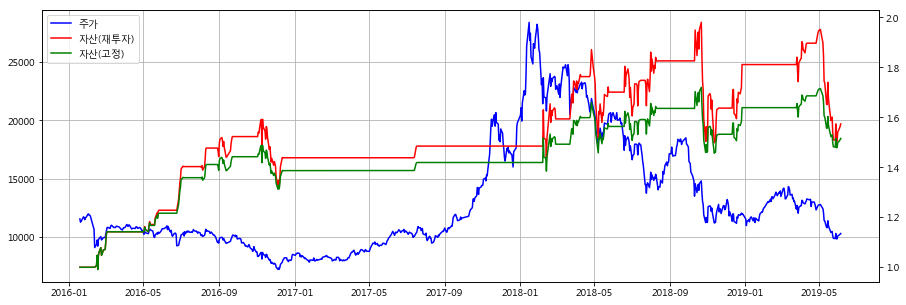

In [88]:
# 그래프 그리기
# 특정기간만 보기
df_graph1= 계좌평가결과1.loc['20150202':'20190830'].copy()
df_graph2= 계좌평가결과2.loc['20150202':'20190830'].copy()
fig= plt.figure(figsize=(15,5))

원금 = 10000000

ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph1['date'], df_graph1['현재가'], color='b', label='주가')
line2= ax2.plot(df_graph1['date'], (df_graph1['총자산'] - 원금 ) / 원금 + 1, color='r', label='자산(재투자)')
line3= ax2.plot(df_graph1['date'], (df_graph2['총자산'] - 원금 ) / 원금 + 1, color='g', label='자산(고정)')

# 축의 틱간격설정
# ax1.set_yticks(np.arange(-3, 3, step=0.25))
# ax2.set_yticks(np.arange(300, 3000, step=100))

# 축의 범위설정
# ax1.set_ylim(-1.75 , 2.5)
# ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2+line3
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)

ax1.grid()
plt.show()


# ax1.plot(df_graph[df_graph['TS']==1]['date'], df_graph[df_graph['TS']==1]['매수가'], '^', color='r', label='buy')
# ax1.plot(df_graph[df_graph['TS']==-1]['date'], df_graph[df_graph['TS']==-1]['매도가'], '^', color='b', label='sell')



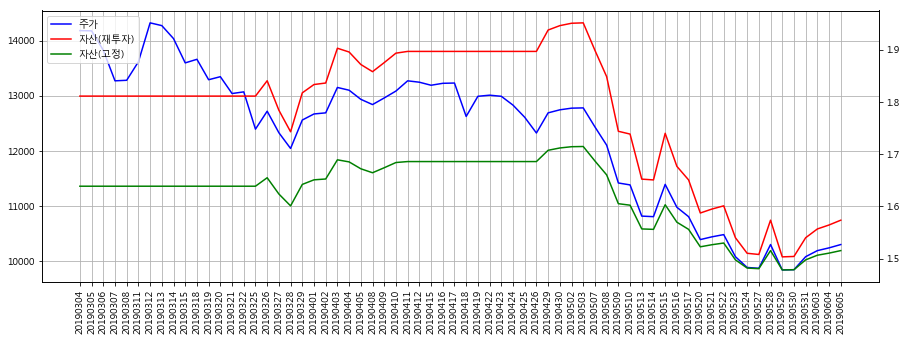

In [89]:
# 그래프 그리기
# 특정기간만 보기
df_graph1= 계좌평가결과1.loc['20190302':'20190830'].copy()
df_graph2= 계좌평가결과2.loc['20190302':'20190830'].copy()
fig= plt.figure(figsize=(15,5))

원금 = 10000000

# x축 틱설정
xticks= pd.date_range(start=df_graph1.index.min(), end=df_graph1.index.max(), freq='D')
xticks_name= [d for d in xticks.strftime('%y-%m-%d')]


ax1= fig.subplots()
line1= ax1.plot(df_graph1.index, df_graph1['현재가'], color='b', label='주가')
plt.xticks(xticks, xticks_name, rotation= 90)


ax2= ax1.twinx() # y축 2축 그래프 그리기
line2= ax2.plot(df_graph1.index, (df_graph1['총자산'] - 원금 ) / 원금 + 1, color='r', label='자산(재투자)')
line3= ax2.plot(df_graph1.index, (df_graph2['총자산'] - 원금 ) / 원금 + 1, color='g', label='자산(고정)')


#레이블 표시하기
lines= line1+line2+line3
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)

ax1.grid()
plt.show()



In [90]:
print('재투자')
print('==================')
print('거래횟수:',len(거래결과1), '/', len(계좌평가결과1))
print('수익: ', len(거래결과1['수익'][거래결과1['수익']>0]))
print('손실: ', len(거래결과1['수익'][거래결과1['수익']<0]))
print('보합: ', len(거래결과1['수익'][거래결과1['수익']== 0]))
print('수익합:', 거래결과1['수익'].sum(), '원')
print('수익률:', (거래결과1['수익'].sum()/원금)*100, '%')

재투자
거래횟수: 16 / 827
수익:  13
손실:  3
보합:  0
수익합: 8968095 원
수익률: 89.68095000000001 %


In [91]:
print('고정')
print('==================')
print('거래횟수:',len(거래결과2), '/', len(계좌평가결과2))
print('수익: ', len(거래결과2['수익'][거래결과1['수익']>0]))
print('손실: ', len(거래결과2['수익'][거래결과1['수익']<0]))
print('보합: ', len(거래결과2['수익'][거래결과1['수익']== 0]))
print('수익합:', 거래결과2['수익'].sum(), '원')
print('수익률:', (거래결과2['수익'].sum()/원금)*100, '%')

고정
거래횟수: 16 / 827
수익:  13
손실:  3
보합:  0
수익합: 6859794 원
수익률: 68.59794000000001 %


In [21]:
거래결과1.tail()

,매수가,매도가,수익,수익률
일자,,,,
20190328,6987,7060,126331,1.01
20190405,6867,6810,-108124,-0.86
20190408,6875,6830,-85359,-0.68
20190409,6887,6855,-61242,-0.49
20190410,6917,6860,-105197,-0.85


In [22]:
# 결과 csv 저장
계좌평가결과1.to_csv('./result_%s.csv'%(stock_code))


In [ ]:
# MDD 등 리포트 작성
# 엑셀리포팅